# NavierStokes Machine - Experimental Project for Machine Learning Capstone
### Objective:
Try to apply machine learning techniques to improve the speed in CFD simulations.
#### References:
Data-driven projection method in fluid simulation (Cheng Yang, Xubo Yang* and Xiangyun Xiao,2016)
#### Notes:
This is just an initial experimentation to see if the results are consistent.
The simulations for the CFD were done with OpenFOAM v.4 for transient incompressible flow, using the **pimpleFoam** solver.

----
## Data Preparation
The simulation chosen was a 2D transient incompressible fluid passing through a box. First, extract the input data. The input data is equal to the physical attributes of the fluid in the time-step 0.1. The output is the pressure field for the followring time-step (0.11).

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import sklearn as sk
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

First is the extraction of the input data.

In [39]:
file_list = []
file_list.append(pd.read_table('meshcoord.txt',sep="\s+"))
file_list.append(pd.read_table('0.1/pressure.txt'))
file_list.append(pd.read_csv('0.1/velocity.txt',sep="\s+"))
df = pd.DataFrame()
df = pd.concat(file_list,axis=1)
df = df.drop(['vz','v','ccz'],axis=1)
df.head()

,ccx,ccy,pressure,vx,vy
0,0.01,0.01,0.000427,0.006651,0.000037
1,0.03,0.01,0.000119,0.010985,0.000031
2,0.05,0.01,0.000162,0.009897,0.000023
3,0.07,0.01,0.000170,0.009788,0.000022
4,0.09,0.01,0.000168,0.009768,0.000022


Checking to see if the data was imported correctly.

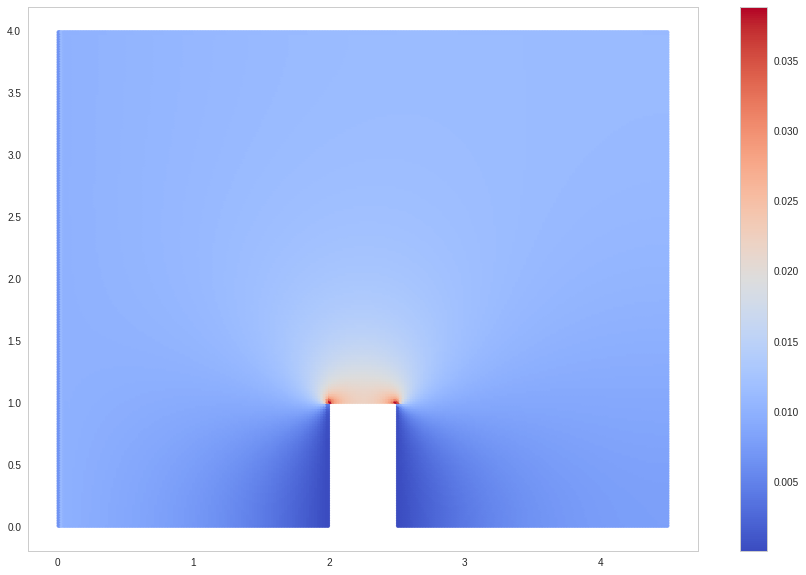

In [40]:
plt.figure(figsize=(15,10))
plt.scatter(df.ccx,df.ccy,c=df.vx,s=20.,cmap='coolwarm')
plt.colorbar()

Dividing the data in a grid format (puting into an image like format), for easier manipulation.

In [41]:
vx,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(225,200))
vy,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vy,bins=(225,200))
p,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.pressure,bins=(225,200))
_,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(224,199))

Creating a Boundary variable ("o" for obstacle). This represents areas in that were "walls", "inlets" or "outlets", in which boundary conditions were prescribed.

In [42]:
o = np.zeros((225,200))
xg, yg = np.meshgrid(np.arange(100,125,1),np.arange(0,50,1))
for i in np.arange(100,125,1):
    for j in np.arange(0,50,1):
        o[i,j] = 1

Creating a padding accross the simulation domain.

In [43]:
VY = np.vstack((np.zeros(200),vy,np.zeros(200)))
VY = np.hstack((np.zeros((227,1)),VY,np.zeros((227,1))))
VX = np.vstack((np.zeros(200),vx,np.zeros(200)))
VX = np.hstack((np.zeros((227,1)),VX,np.zeros((227,1))))
P = np.vstack((np.zeros(200),p,np.zeros(200)))
P = np.hstack((np.zeros((227,1)),P,np.zeros((227,1))))
O = np.vstack((np.ones(200)+5,o,np.ones(200)+2))
O = np.hstack((np.ones((227,1)),O,np.ones((227,1))))


Adjusting the matrix direction and checking if the final result is what was expected.

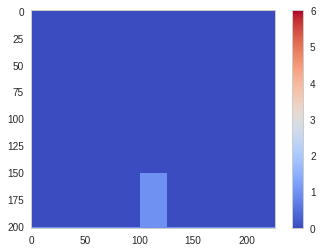

In [44]:
VX = VX.T[::-1]
VY = VY.T[::-1]
P  = P.T[::-1]
O  = O.T[::-1]

plt.imshow(O,cmap='coolwarm')
plt.colorbar()

The data preparation for the input looks good. The Boundary variable shows that the obstacle was captures correctly. Next, time to try some machine learning to predict the pressure in each cell based on velocity, pressure and boundary of the previous time-step.

Now is the extraction of the output data, the pressure field in the following time-step.

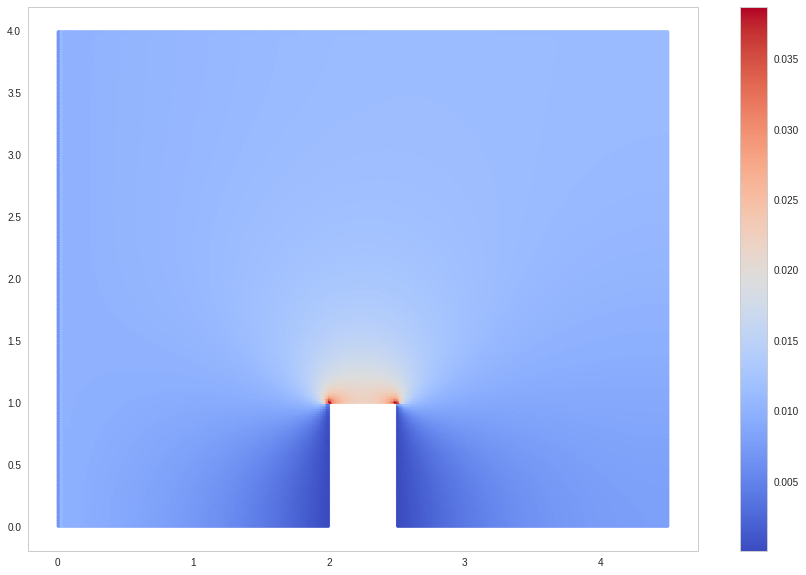

In [45]:
file_list = []
file_list.append(pd.read_table('meshcoord.txt',sep="\s+"))
file_list.append(pd.read_table('0.11/pressure.txt'))
file_list.append(pd.read_csv('0.11/velocity.txt',sep="\s+"))
df = pd.DataFrame()
df = pd.concat(file_list,axis=1)
df = df.drop(['vz','v','ccz'],axis=1)
plt.figure(figsize=(15,10))
plt.scatter(df.ccx,df.ccy,c=df.vx,s=20.,cmap='coolwarm')
plt.colorbar()

In [46]:
poutput,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.pressure,bins=(225,200))
vx,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(225,200))
vy,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vy,bins=(225,200))
_,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(224,199))
Poutput = np.vstack((np.zeros(200),poutput,np.zeros(200)))
Poutput = np.hstack((np.zeros((227,1)),Poutput,np.zeros((227,1))))
VYoutput = np.vstack((np.zeros(200),vy,np.zeros(200)))
VYoutput = np.hstack((np.zeros((227,1)),VYoutput,np.zeros((227,1))))
VXoutput = np.vstack((np.zeros(200),vx,np.zeros(200)))
VXoutput = np.hstack((np.zeros((227,1)),VXoutput,np.zeros((227,1))))
VXoutput = VXoutput.T[::-1]
VYoutput = VYoutput.T[::-1]
Poutput  = Poutput.T[::-1]

### Learning to estimate pressure for the next time-step
First, let's do a simpler model, in which only the neighbour cells behaviour and the current state influences the following result. So, we create a DataFrame in which the input are the pressure, velocity and boundary variable around and inside the cell. The output is the inside pressure in the next time-step.

In [47]:
plist = []
for i in np.arange(1,201,1):
    for j in np.arange(1,226,1):
        plist.append({'pin':P[i,j],'pright':P[i,j-1],'pleft':P[i,j+1],
                       'pup':P[i-1,j],'pdown':P[i+1,j],'output':Poutput[i,j],
                      'vxin':VX[i,j],'vright':VX[i,j-1],'vleft':VX[i,j+1],
                      'vup':VY[i-1,j],'vdown':VY[i+1,j],'vyin':VY[i,j],
                      'vxoutin':VXoutput[i,j],'voutright':VXoutput[i,j-1],'voutleft':VXoutput[i,j+1],
                      'voutup':VYoutput[i-1,j],'voutdown':VYoutput[i+1,j],'vyoutin':VYoutput[i,j],
                      'oin':O[i,j],'oright':O[i,j-1],'oleft':O[i,j+1],
                      'oup':O[i-1,j],'odown':O[i+1,j],
                      'ccx':ccx[j-1],'ccy':ccy[-i]
                     })

In [48]:
data= pd.DataFrame(plist)

In [49]:
data.head()

,ccx,ccy,odown,oin,oleft,oright,oup,output,pdown,pin,...,voutdown,voutleft,voutright,voutup,vright,vup,vxin,vxoutin,vyin,vyoutin
0,0.01,3.99,0.0,0.0,0.0,6.0,1.0,0.000305,0.000339,0.000344,...,-0.000002,0.011088,0.000000,0.0,0.000000,0.0,0.006674,0.006762,-0.000012,-0.000014
1,0.03,3.99,0.0,0.0,0.0,0.0,1.0,0.000028,0.000034,0.000036,...,0.000011,0.010033,0.006762,0.0,0.006674,0.0,0.011066,0.011088,-0.000003,-0.000004
2,0.05,3.99,0.0,0.0,0.0,0.0,1.0,0.000075,0.000078,0.000079,...,0.000016,0.009980,0.011088,0.0,0.011066,0.0,0.010041,0.010033,0.000006,0.000005
3,0.07,3.99,0.0,0.0,0.0,0.0,1.0,0.000083,0.000087,0.000087,...,0.000019,0.010022,0.010033,0.0,0.010041,0.0,0.009987,0.009980,0.000006,0.000006
4,0.09,3.99,0.0,0.0,0.0,0.0,1.0,0.000080,0.000084,0.000084,...,0.000020,0.010035,0.009980,0.0,0.009987,0.0,0.010026,0.010022,0.000007,0.000007


In [50]:
data.describe()

,ccx,ccy,odown,oin,oleft,oright,oup,output,pdown,pin,...,voutdown,voutleft,voutright,voutup,vright,vup,vxin,vxoutin,vyin,vyoutin
count,45000.00000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,4.500000e+04,4.500000e+04,4.500000e+04,...,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,2.25000,2.000000,0.032778,0.027778,0.041111,0.054444,0.032222,4.124146e-05,4.402676e-05,4.422227e-05,...,0.000280,0.009961,0.009946,0.000280,0.009946,0.000280,0.009990,0.009991,0.000280,0.000280
std,1.29904,1.154699,0.178056,0.164337,0.257078,0.429904,0.176592,6.216921e-05,6.572652e-05,6.569212e-05,...,0.002215,0.003125,0.003131,0.002215,0.003132,0.002215,0.003061,0.003061,0.002215,0.002215
min,0.01000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.762280e-03,-1.751720e-03,-1.751720e-03,...,-0.033987,0.000000,0.000000,-0.033987,0.000000,-0.034107,0.000000,0.000000,-0.034107,-0.033987
25%,1.13000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,3.941795e-07,1.321277e-07,2.836490e-07,...,-0.000313,0.009413,0.009375,-0.000313,0.009374,-0.000313,0.009413,0.009413,-0.000313,-0.000313
50%,2.25000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.363160e-05,2.548110e-05,2.608460e-05,...,0.000032,0.010774,0.010767,0.000029,0.010767,0.000029,0.010773,0.010774,0.000032,0.000032
75%,3.37000,2.995000,0.000000,0.000000,0.000000,0.000000,0.000000,6.964930e-05,7.407243e-05,7.411190e-05,...,0.001100,0.011346,0.011346,0.001100,0.011346,0.001100,0.011346,0.011346,0.001100,0.001100
max,4.49000,3.990000,1.000000,1.000000,3.000000,6.000000,1.000000,3.840270e-04,4.268880e-04,4.268880e-04,...,0.035885,0.038701,0.038701,0.035885,0.038819,0.035895,0.038819,0.038701,0.035895,0.035885


In [51]:
dataoutput = data.output.copy()
datainput = data.drop(['output','vxoutin','vyoutin','voutright',
                       'voutleft','voutup','voutdown','ccx','ccy'],axis=1).copy()

In [52]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    # TODO: Implement Function
    return x

dataoutput = normalize(dataoutput)
datainput  = normalize(datainput)

In [53]:
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(datainput, dataoutput, test_size = 0.2, random_state = 3)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36000 samples.
Testing set has 9000 samples.


In [54]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

clf = DecisionTreeRegressor(random_state=52)
# clf = RandomForestRegressor(random_state=52,n_estimators=30)
clf = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train)
r2_score(y_test,predictions_test)

0.99520562232316556

If just guessed the previous pressure.

In [55]:
r2_score(dataoutput,datainput.pin)

0.69419658124154537

Trying something different... Let's try to find the current pressure based on the current velocity field.

In [56]:
datainput = data.drop(['pin','pleft','pright','pup','pdown','ccx','ccy','output','vxoutin','vyoutin','voutright',
                       'voutleft','voutup','voutdown'],axis=1).copy()
dataoutput = data['pin'].copy()
dataoutput = normalize(dataoutput)
datainput  = normalize(datainput)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(datainput, dataoutput, test_size = 0.2, random_state = 2)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
clf = DecisionTreeRegressor(random_state=10)
clf = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train)
r2_score(y_test,predictions_test)

Training set has 36000 samples.
Testing set has 9000 samples.


0.98699886183599816

In [58]:
clf.predict(datainput)

array([ 0.8043883 ,  0.82076225,  0.84001788, ...,  0.80386047,
        0.80386047,  0.80386047])

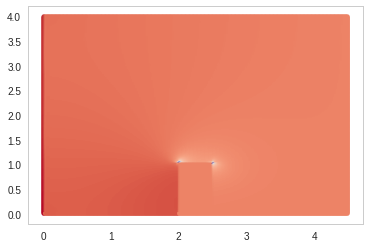

In [59]:
plt.scatter(data.ccx,data.ccy,c=data.pin,s=20.,cmap='coolwarm')

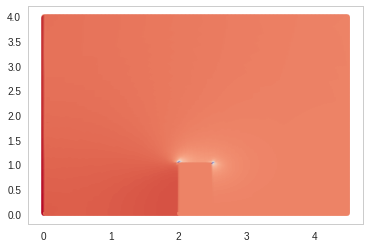

In [60]:
plt.scatter(data.ccx,data.ccy,c=clf.predict(datainput),s=20.,cmap='coolwarm')

### Testing velocity prediction for next time-step

In [72]:
dataoutput = data.vyoutin.copy()
datainput = data.drop(['output','vxoutin','vyoutin','voutright',
                       'voutleft','voutup','voutdown','ccx','ccy'],axis=1).copy()
# dataoutput = normalize(dataoutput)
# datainput  = normalize(datainput)

X_train, X_test, y_train, y_test = train_test_split(datainput, dataoutput, test_size = 0.2, random_state = 3)
clf = DecisionTreeRegressor(random_state=52)
# clf = RandomForestRegressor(random_state=52,n_estimators=30)
clf = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train)
print(r2_score(y_test,predictions_test))
print(r2_score(dataoutput,datainput.vyin))

0.990830258446
0.999998280128


In [74]:
datainput.vyin

0       -1.194800e-05
1       -2.823730e-06
2        5.522140e-06
3        6.260380e-06
4        6.723800e-06
5        7.012440e-06
6        7.168100e-06
7        7.261580e-06
8        7.321220e-06
9        7.360470e-06
10       7.386620e-06
11       7.403880e-06
12       7.414780e-06
13       7.420960e-06
14       7.423500e-06
15       7.423130e-06
16       7.420350e-06
17       7.415540e-06
18       7.408970e-06
19       7.400820e-06
20       7.391250e-06
21       7.380360e-06
22       7.368250e-06
23       7.354960e-06
24       7.340560e-06
25       7.325060e-06
26       7.308510e-06
27       7.290920e-06
28       7.272300e-06
29       7.252660e-06
             ...     
44970   -1.573450e-05
44971   -1.508020e-05
44972   -1.443910e-05
44973   -1.381040e-05
44974   -1.319370e-05
44975   -1.258860e-05
44976   -1.199430e-05
44977   -1.141050e-05
44978   -1.083670e-05
44979   -1.027230e-05
44980   -9.716790e-06
44981   -9.169770e-06
44982   -8.630730e-06
44983   -8.099200e-06
44984   -7

### Testing another time-step

0.713543633247


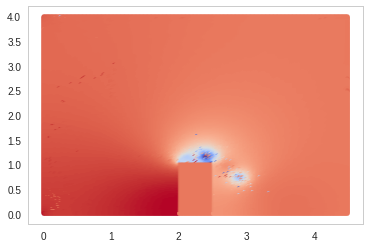

In [107]:
file_list = []
file_list.append(pd.read_table('meshcoord.txt',sep="\s+"))
file_list.append(pd.read_table('98/pressure.txt'))
file_list.append(pd.read_csv('98/velocity.txt',sep="\s+"))
df = pd.DataFrame()
df = pd.concat(file_list,axis=1)
df = df.drop(['vz','v','ccz'],axis=1)

vx,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(225,200))
vy,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vy,bins=(225,200))
p,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.pressure,bins=(225,200))
_,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(224,199))
o = np.zeros((225,200))
xg, yg = np.meshgrid(np.arange(100,125,1),np.arange(0,50,1))
for i in np.arange(100,125,1):
    for j in np.arange(0,50,1):
        o[i,j] = 1
VY = np.vstack((np.zeros(200),vy,np.zeros(200)))
VY = np.hstack((np.zeros((227,1)),VY,np.zeros((227,1))))
VX = np.vstack((np.zeros(200),vx,np.zeros(200)))
VX = np.hstack((np.zeros((227,1)),VX,np.zeros((227,1))))
P = np.vstack((np.zeros(200),p,np.zeros(200)))
P = np.hstack((np.zeros((227,1)),P,np.zeros((227,1))))
O = np.vstack((np.ones(200)+5,o,np.ones(200)+2))
O = np.hstack((np.ones((227,1)),O,np.ones((227,1))))
VX = VX.T[::-1]
VY = VY.T[::-1]
P  = P.T[::-1]
O  = O.T[::-1]

plist = []
for i in np.arange(1,201,1):
    for j in np.arange(1,226,1):
        plist.append({'pin':P[i,j],'pright':P[i,j-1],'pleft':P[i,j+1],
                       'pup':P[i-1,j],'pdown':P[i+1,j],
                      'vxin':VX[i,j],'vright':VX[i,j-1],'vleft':VX[i,j+1],
                      'vup':VY[i-1,j],'vdown':VY[i+1,j],'vyin':VY[i,j],
                      'oin':O[i,j],'oright':O[i,j-1],'oleft':O[i,j+1],
                      'oup':O[i-1,j],'odown':O[i+1,j],
                      'ccx':ccx[j-1],'ccy':ccy[-i]
                     })
data= pd.DataFrame(plist)
datainput = data.drop(['pin','pleft','pright','pup','pdown','ccx','ccy'],axis=1).copy()
dataoutput = data['pin'].copy()
dataoutput = normalize(dataoutput)
datainput  = normalize(datainput)

X_train, X_test, y_train, y_test = train_test_split(datainput, dataoutput, test_size = 0.2, random_state = 20)
clf = DecisionTreeRegressor(random_state=5)
clf = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train)
print(r2_score(y_test,predictions_test))
plt.scatter(data.ccx,data.ccy,c=clf.predict(datainput),s=20.,cmap='coolwarm')

### Testing a new simulation that used simpleFoam

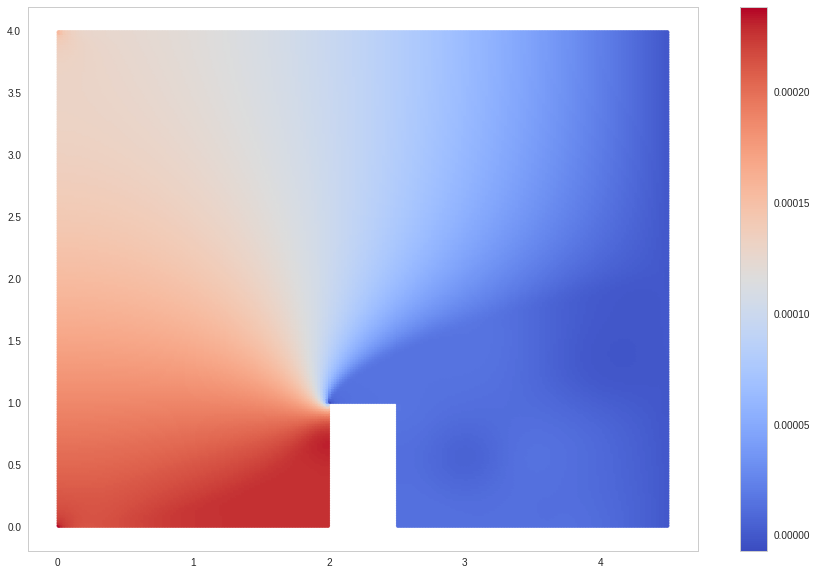

In [31]:
file_list = []
file_list.append(pd.read_table('meshcoord.txt',sep="\s+"))
file_list.append(pd.read_table('716/pressure.txt'))
file_list.append(pd.read_csv('716/velocity.txt',sep="\s+"))
df = pd.DataFrame()
df = pd.concat(file_list,axis=1)
df = df.drop(['vz','v','ccz'],axis=1)
plt.figure(figsize=(15,10))
plt.scatter(df.ccx,df.ccy,c=df.pressure,s=20.,cmap='coolwarm')
plt.colorbar()

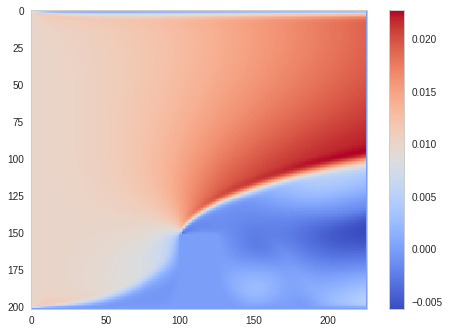

In [32]:
vx,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(225,200))
vy,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vy,bins=(225,200))
p,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.pressure,bins=(225,200))
_,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(224,199))
o = np.zeros((225,200))
xg, yg = np.meshgrid(np.arange(100,125,1),np.arange(0,50,1))
for i in np.arange(100,125,1):
    for j in np.arange(0,50,1):
        o[i,j] = 1
VY = np.vstack((np.zeros(200),vy,np.zeros(200)))
VY = np.hstack((np.zeros((227,1)),VY,np.zeros((227,1))))
VX = np.vstack((np.zeros(200),vx,np.zeros(200)))
VX = np.hstack((np.zeros((227,1)),VX,np.zeros((227,1))))
P = np.vstack((np.zeros(200),p,np.zeros(200)))
P = np.hstack((np.zeros((227,1)),P,np.zeros((227,1))))
O = np.vstack((np.ones(200)+5,o,np.ones(200)+2))
O = np.hstack((np.ones((227,1)),O,np.ones((227,1))))
VX = VX.T[::-1]
VY = VY.T[::-1]
P  = P.T[::-1]
O  = O.T[::-1]

plt.imshow(VX,cmap='coolwarm')
plt.colorbar()

In [33]:
plist = []
for i in np.arange(1,201,1):
    for j in np.arange(1,226,1):
        plist.append({'pin':P[i,j],'pright':P[i,j-1],'pleft':P[i,j+1],
                       'pup':P[i-1,j],'pdown':P[i+1,j],
                      'vxin':VX[i,j],'vright':VX[i,j-1],'vleft':VX[i,j+1],
                      'vup':VY[i-1,j],'vdown':VY[i+1,j],'vyin':VY[i,j],
                      'oin':O[i,j],'oright':O[i,j-1],'oleft':O[i,j+1],
                      'oup':O[i-1,j],'odown':O[i+1,j],
                      'ccx':ccx[j-1],'ccy':ccy[-i]
                     })
data= pd.DataFrame(plist)

In [35]:
datainput = data.drop(['pin','pleft','pright','pup','pdown','ccx','ccy'],axis=1).copy()
dataoutput = data['pin'].copy()
dataoutput = normalize(dataoutput)
# datainput  = normalize(datainput)

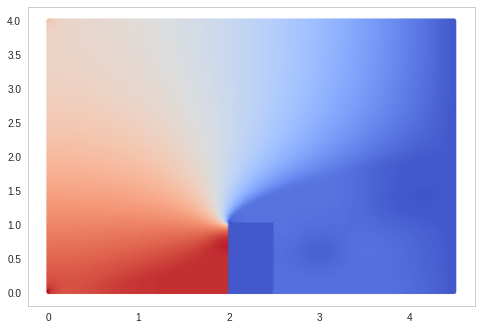

In [36]:
plt.scatter(data.ccx,data.ccy,c=dataoutput*(data.pin.max()-data.pin.min()),s=20.,cmap='coolwarm')

0.925963583821


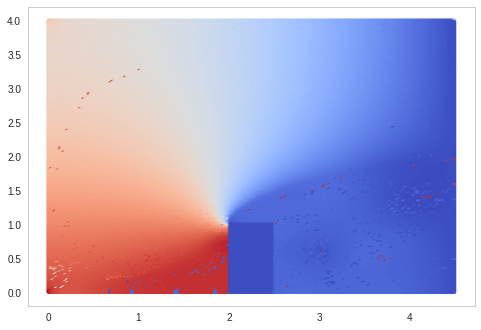

In [37]:
X_train, X_test, y_train, y_test = train_test_split(datainput, dataoutput, test_size = 0.2, random_state = 20)
clf = DecisionTreeRegressor(random_state=5)
clf = clf.fit(X_train,y_train)
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train)
print(r2_score(y_test,predictions_test))
plt.scatter(data.ccx,data.ccy,c=clf.predict(datainput),s=20.,cmap='coolwarm')